# **PE Inpainting : Création d'un modèle d'inptaing**

##### **Librairie à installer**

- pip install kaggle
- pip install torch
- pip install porespy
- pip install pillow
- pip install opencv-python
- pip install heapq

Pour télécharger les données, utiliser l'API de kaggle :
créer un fichier kaggle.json contenant vos identifiants Kaggle à partir de la page de votre compte Kaggle (https://www.kaggle.com/ -> Your Account -> Create New API Token)
```json
{
  "username": "YOUR_USERNAME",
  "key": "YOUR_KEY"
}
```

effectuer les commandes suivantes pour placer le fichier json dans .kaggle :

```bash
mkdir ~/.kaggle
mv kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
```

Enfin il faut télécharger les datasets depuis kaggle
```bash
kaggle datasets download -d jessicali9530/celeba-dataset
kaggle datasets download -d nickj26/places2-mit-dataset
```

Une fois les datasets téléchargés, il suffit simplement de renseigner le bon path dans l'appel des fonctions :
```python 
datasets.ImageFolder()
```

## **1. Import des données**

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# définition de la taille des images
img_size = 64

# 1. Charger le dataset
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalise les valeurs des pixels entre -1 et 1
])

dataset_celeba = datasets.ImageFolder('img_align_celeba', transform=transform)

In [2]:
dataset_celeba

Dataset ImageFolder
    Number of datapoints: 202599
    Root location: data/img_align_celeba
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [3]:
places365_data = datasets.ImageFolder("data_256", transform=transform)
places365_data

Dataset ImageFolder
    Number of datapoints: 1803466
    Root location: data_256
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

## **2. Création du dataset d'entraînement**

### **2.1. Concatenation des datasets CelebA et Places365**

In [4]:
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset

num_samples = 200000
celeba_subset_size = num_samples // 2
places365_subset_size = num_samples - celeba_subset_size

celeba_subset_indices = np.random.choice(len(dataset_celeba), celeba_subset_size, replace=False)
places365_subset_indices = np.random.choice(len(places365_data), places365_subset_size, replace=False)

celeba_subset = Subset(dataset_celeba, celeba_subset_indices)
places365_subset = Subset(places365_data, places365_subset_indices)

combined_dataset = ConcatDataset([celeba_subset, places365_subset])

### **2.2. Génération des masques**

Fonction pour générer des lignes de tailles aléatoires dans des zones aléatoires de l'image

In [411]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def generate_line_irregular_mask(height, width, max_num_lines=10, min_thickness=1, max_thickness=5):
    """
    Génère un masque irrégulier pour une image de taille spécifiée.

    Args:
        height (int): hauteur de l'image
        width (int): largeur de l'image
        max_num_lines (int): nombre maximum de lignes aléatoires à dessiner
        min_thickness (int): épaisseur minimale des lignes aléatoires
        max_thickness (int): épaisseur maximale des lignes aléatoires

    Returns:
        mask: masque binaire avec des dimensions (height, width)
    """
    mask = np.ones((height, width), dtype=np.float32)
    num_lines = np.random.randint(1, max_num_lines)

    for _ in range(num_lines):
        # Choix de deux points aléatoires
        x1, y1 = np.random.randint(0, width), np.random.randint(0, height)
        x2, y2 = np.random.randint(0, width), np.random.randint(0, height)

        # Choix d'une épaisseur aléatoire pour la ligne
        thickness = np.random.randint(min_thickness, max_thickness)

        # Dessin d'une ligne noire entre les deux points
        cv2.line(mask, (x1, y1), (x2, y2), color=0, thickness=thickness)

    return mask

Fonction qui permet de créer des masques à la fois de formes irrégulières et des masques linéaires

In [432]:
import random
import porespy as ps
def generate_irregular_mask(height, width):
    porosity = random.uniform(0.6, 1)
    blobiness = random.uniform(0.2, 0.8)
    
    im = ps.generators.blobs(shape=[height, width], porosity=porosity, blobiness=blobiness) + generate_line_irregular_mask(height=height, width=width)
    
    im[im == 1] = 0
    im[im == 2] = 1
    return im

In [6]:
dataset_img = places365_data

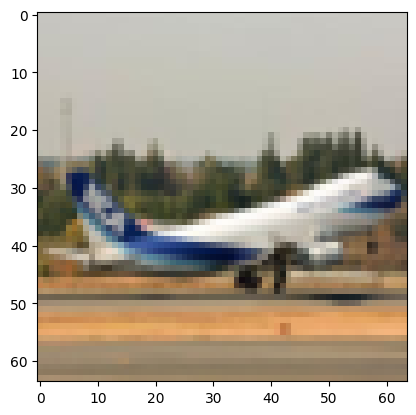

In [7]:
plt.imshow(dataset_img[4][0].permute(1, 2, 0))

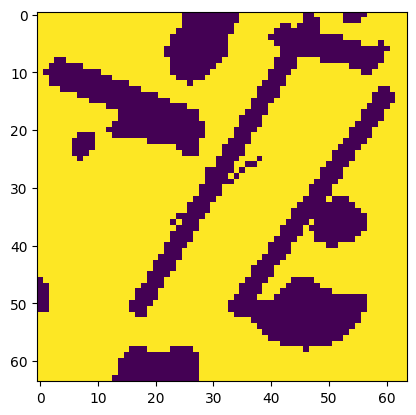

In [435]:
plt.imshow(generate_irregular_mask(height=img_size, width=img_size))
plt.savefig('ex_mask.png')

Fonction pour créer un dataset avec des images masquées, les masques correspondants et les images originales

In [436]:
from torch.utils.data import Dataset

class MaskedDataset(Dataset):
    def __init__(self, dataset, mask_func):
        self.dataset = dataset
        self.mask_func = mask_func

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        height, width = img.shape[1], img.shape[2]

        # Générer un masque aléatoire
        mask = self.mask_func(height, width)

        # Appliquer le masque à l'image
        masked_img = img * torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return masked_img, torch.tensor(mask, dtype=torch.float32).repeat(3, 1, 1), img

    def __len__(self):
        return len(self.dataset)


In [437]:
# Créer un dataset masqué et un DataLoader
masked_dataset = MaskedDataset(combined_dataset, generate_irregular_mask)
# dataset_img_loader = DataLoader(masked_dataset, batch_size=64, shuffle=True)
dataset_img_loader = DataLoader(masked_dataset, batch_size=128, shuffle=True, num_workers=4)

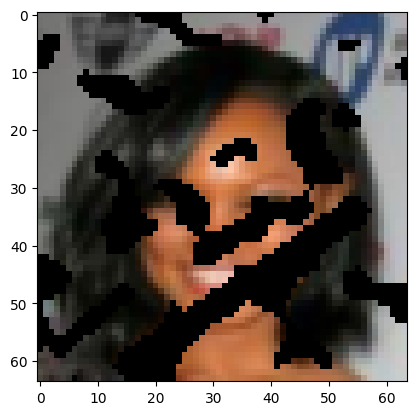

In [736]:
a = next(iter(dataset_img_loader))
plt.imshow(a[0][0].permute(1, 2, 0))

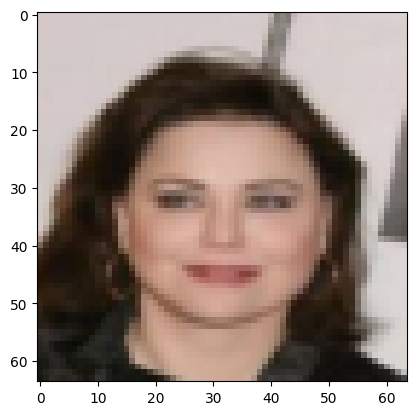

In [439]:
plt.imshow(a[2][0].permute(1, 2, 0))

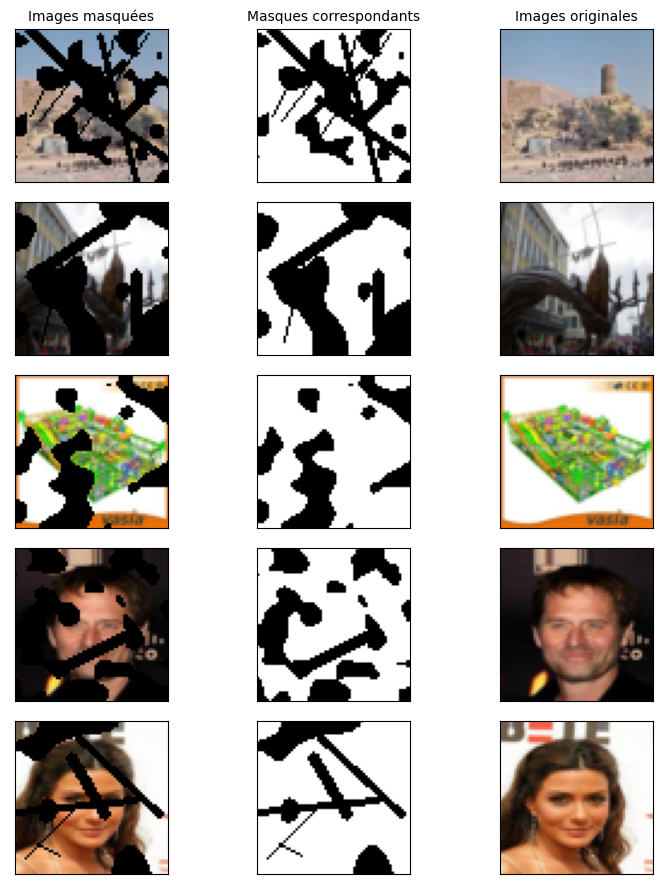

In [497]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(8,9))
axs[0][0].set_title('Images masquées', fontsize=10)
axs[0][1].set_title('Masques correspondants', fontsize=10)
axs[0][2].set_title('Images originales', fontsize=10)
for i in range(5):
    
    axs[i][0].imshow(a[0][i].permute(1, 2, 0))
    
    axs[i][1].imshow(a[1][i].permute(1, 2, 0))
    
    axs[i][2].imshow(a[2][i].permute(1, 2, 0))
    
    
    for ax in axs:
        for j in ax:
            j.set_xticks([])
            j.set_yticks([])

plt.tight_layout()
plt.savefig('exemple_dataset.png')
plt.show()


## **3. Création des modèles d'Inpainting**

### **3.1. Création du générateur**

In [195]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Décodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, masked_img, mask):
        x = torch.cat((masked_img, mask), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        generated = x * (1 - mask) # Ne garder que les parties générées où le masque est présent
        full_image = masked_img + generated # Fusionner l'image masquée et les parties générées

        return full_image

### **3.2. Création du discriminateur**

In [195]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # La couche linéaire finale dépend de la taille de l'image en entrée
        self.linear = nn.Sequential(
            nn.Linear(512 * (img_size // 16) * (img_size // 16), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

## **4. Entraînement du GAN**

### **4.1. Instanciation des modeles**

In [16]:
generator_GAN = Generator()
discriminator_GAN = Discriminator()

### **4.2. Création d'une fonction pour pouvoir afficher des predictions à la fin de chaque epoch**

In [506]:
from matplotlib.pyplot import Line2D

def plot_preds(num_img, preds, image_masked, real_images, gen_loss, disc_loss):
    # Créer une grille 1x3 pour afficher les images
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

    num_img = 63

    # Obtenir les images à afficher
    image_gen = preds[num_img].permute(1, 2, 0).detach()
    image_mas = image_masked[num_img].permute(1, 2, 0)
    real_img = real_images[num_img].permute(1, 2, 0)

    # Ajouter chaque image à la grille
    axs[0].imshow(image_gen)
    axs[0].set_title('Generated Image')
    
    axs[1].imshow(image_mas)
    axs[1].set_title('Masked Image')
    
    axs[2].imshow(real_img)
    axs[2].set_title('Real Image')

    # Ajouter la légende globale
    legend_elements = [Line2D([0], [0], color='b', lw=4, label='Generator Loss: {:.4f}'.format(gen_loss)),
                       Line2D([0], [0], color='r', lw=4, label='Discriminator Loss: {:.4f}'.format(disc_loss))]

    fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.3, -0.15))

    # Masquer les axes des sous-graphes
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust layout to make sure everything fits
    plt.tight_layout()

    # Afficher la grille d'images
    plt.show()

    return fig

### **4.3. Définition des hyperparamètres**

In [370]:
import torch.optim as optim
from tqdm import tqdm
import os

# Hyperparamètres
num_epochs = 40
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

# Fonction de perte (Binary Cross Entropy)
criterion = nn.BCELoss()

g_losses = []
d_losses = []

# Optimiseurs pour le générateur et le discriminateur
optimizer_G = optim.Adam(generator_GAN.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator_GAN.parameters(), lr=learning_rate, betas=(beta1, beta2))

# Boucle d'entraînement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_GAN.to(device)
discriminator_GAN.to(device)

# Créez un dossier pour enregistrer les résultats
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

### **4.4 Boucle d'entraînement des deux modèles**

100%|██████████| 1563/1563 [1:52:53<00:00,  4.33s/it]

Epoch [1/40], Discriminator Loss: 0.36505213379859924, Generator Loss: 4.19304084777832


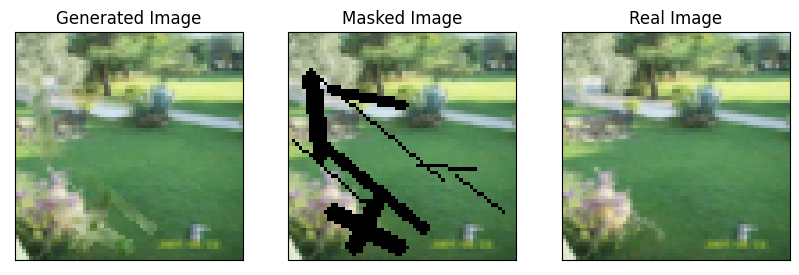

---------------------------------------


100%|██████████| 1563/1563 [1:51:58<00:00,  4.30s/it]

Epoch [2/40], Discriminator Loss: 0.02302449941635132, Generator Loss: 4.631774425506592


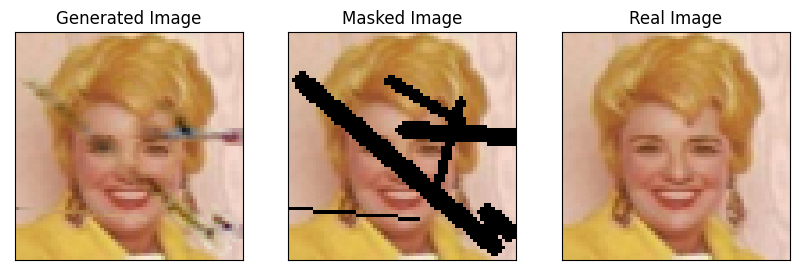

---------------------------------------


 39%|███▊      | 604/1563 [43:19<1:06:41,  4.17s/it]

In [ ]:
for epoch in range(num_epochs):
    for i, (masked_images, masks, real_images) in enumerate(tqdm(dataset_img_loader)):
        batch_size = masked_images.size(0)

        # Labels réels et faux pour la fonction de perte
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        # Entraînement du discriminateur
        # ---------------------
        discriminator_GAN.zero_grad()

        # Calculer la perte pour les images réelles
        real_output = discriminator_GAN(real_images.to(device))
        d_loss_real = criterion(real_output, real_labels)

        # Calculer la perte pour les images générées
        fake_images = generator_GAN(masked_images.to(device), masks.to(device))
        fake_output = discriminator_GAN(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        # Optimiser le discriminateur
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # Entraînement du générateur
        # ---------------------
        generator_GAN.zero_grad()

        # Calculer la perte pour les images générées
        fake_output = discriminator_GAN(fake_images)
        g_loss = criterion(fake_output, real_labels)

        # Optimiser le générateur
        g_loss.backward()
        optimizer_G.step()

    # Afficher les pertes
    print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}")
    
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    # Enregistrer les résultats toutes les 10 epochs
    if (epoch + 1) % 1 == 0:
        a = next(iter(dataset_img_loader))
        image_masked = a[0]
        mask = a[1]
        real_images = a[2]
        preds = generator_GAN(image_masked, mask)

        # Enregistrez l'aperçu des résultats dans le dossier "results"
        fig_preds = plot_preds(1, preds, image_masked, real_images)
        
        fig_preds.savefig(f"{results_dir}/epoch_{epoch + 1}_results.png")
        # Sauvegarder les modèles
        
        torch.save(generator_GAN.state_dict(), f'generator_GAN_epoch_{epoch + 1}.pth')
        torch.save(discriminator_GAN.state_dict(), f'discriminator_GAN_epoch_{epoch + 1}.pth')

    print("---------------------------------------")

### **4.5. Affichage de la Loss des deux modeles en fonction de l'entraînement**

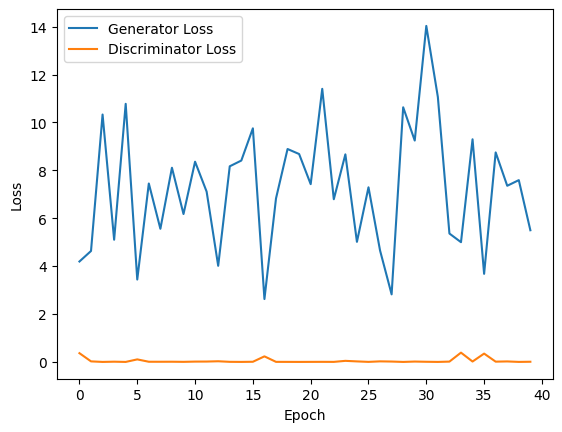

In [498]:
fig2 = plt.figure()
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig2.savefig(f"{results_dir}/losses_GAN2.png")

In [747]:
a = next(iter(dataset_img_loader))
image_masked = a[0]
mask = a[1]
real_images = a[2]
preds = generator_gan_2(image_masked, mask)

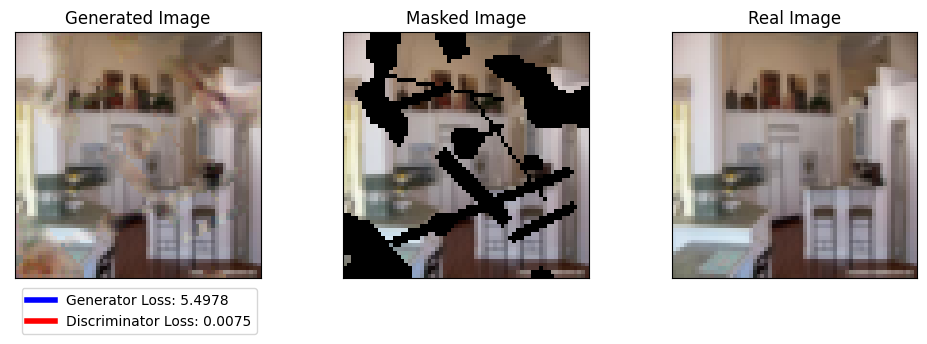

In [750]:
# Enregistrez l'aperçu des résultats dans le dossier "results"
fig_preds = plot_preds(1, preds, image_masked, real_images, g_loss, d_loss)

In [ ]:
# Sauvegarder les modèles
torch.save(generator_GAN.state_dict(), 'generator_GAN.pth')
torch.save(discriminator_GAN.state_dict(), 'discriminator_GAN.pth')

## **5. Algorithme d'Inpainting par FMM**

Tiré du code de Oliver (olvb) sur le repo https://github.com/olvb/pyheal/tree/master

In [751]:
from math import sqrt as sqrt
import heapq
import numpy as np

# flags
KNOWN = 0
BAND = 1
UNKNOWN = 2
# valeurs extrêmes
INF = 1e6 
EPS = 1e-6

In [752]:
# Résout une étape de l'équation d'Eikonal pour trouver le quadrant le plus proche
def _solve_eikonal(y1, x1, y2, x2, height, width, dists, flags):
    # vérifie les limites de l'image
    if y1 < 0 or y1 >= height or x1 < 0 or x1 >= width:
        return INF

    if y2 < 0 or y2 >= height or x2 < 0 or x2 >= width:
        return INF

    flag1 = flags[y1, x1]
    flag2 = flags[y2, x2]

    # les deux pixels sont connus
    if flag1 == KNOWN and flag2 == KNOWN:
        dist1 = dists[y1, x1]
        dist2 = dists[y2, x2]
        d = 2.0 - (dist1 - dist2) ** 2
        if d > 0.0:
            r = sqrt(d)
            s = (dist1 + dist2 - r) / 2.0
            if s >= dist1 and s >= dist2:
                return s
            s += r
            if s >= dist1 and s >= dist2:
                return s
            # pas de solution
            return INF

    # seul le premier pixel est connu
    if flag1 == KNOWN:
        dist1 = dists[y1, x1]
        return 1.0 + dist1

    # seul le second pixel est connu
    if flag2 == KNOWN:
        dist2 = dists[y2, x2]
        return 1.0 + dist2

    # aucun pixel n'est connu
    return INF

In [758]:
# retourne le gradient pour un pixel, calculé sur une plage de 2 pixels si possible
def _pixel_gradient(y, x, height, width, vals, flags):
    val = vals[y, x]

    # calcule grad_y
    prev_y = y - 1
    next_y = y + 1
    if prev_y < 0 or next_y >= height:
        grad_y = INF
    else:
        flag_prev_y = flags[prev_y, x]
        flag_next_y = flags[next_y, x]

        if flag_prev_y != UNKNOWN and flag_next_y != UNKNOWN:
            grad_y = (vals[next_y, x] - vals[prev_y, x]) / 2.0
        elif flag_prev_y != UNKNOWN:
            grad_y = val - vals[prev_y, x]
        elif flag_next_y != UNKNOWN:
            grad_y = vals[next_y, x] - val
        else:
            grad_y = 0.0

    # calcule grad_x
    prev_x = x - 1
    next_x = x + 1
    if prev_x < 0 or next_x >= width:
        grad_x = INF
    else:
        flag_prev_x = flags[y, prev_x]
        flag_next_x = flags[y, next_x]

        if flag_prev_x != UNKNOWN and flag_next_x != UNKNOWN:
            grad_x = (vals[y, next_x] - vals[y, prev_x]) / 2.0
        elif flag_prev_x != UNKNOWN:
            grad_x = val - vals[y, prev_x]
        elif flag_next_x != UNKNOWN:
            grad_x = vals[y, next_x] - val
        else:
            grad_x = 0.0

    return grad_y, grad_x

In [759]:
# calcule les distances entre le contour du masque initial et les pixels hors du masque, en utilisant la méthode Fast Marching (FMM)
def _compute_outside_dists(height, width, dists, flags, band, radius):
    band = band.copy()
    orig_flags = flags
    flags = orig_flags.copy()
    # échange INSIDE / OUTSIDE
    flags[orig_flags == KNOWN] = UNKNOWN
    flags[orig_flags == UNKNOWN] = KNOWN

    last_dist = 0.0
    double_radius = radius * 2
    while band:
        # a atteint la limite du rayon, arrête la FFM
        if last_dist >= double_radius:
            break

        # extrait le pixel BAND le plus proche du contour du masque initial et le marque comme KNOWN
        _, y, x = heapq.heappop(band)
        flags[y, x] = KNOWN

        # traite les voisins immédiats (haut/bas/gauche/droite)
        neighbors = [(y - 1, x), (y, x - 1), (y + 1, x), (y, x + 1)]
        for nb_y, nb_x in neighbors:
            # saute si hors du cadre
            if nb_y < 0 or nb_y >= height or nb_x < 0 or nb_x >= width:
                continue

            # le voisin a déjà été traité, rien à faire
            if flags[nb_y, nb_x] != UNKNOWN:
                continue

            # calcule la distance du voisin au contour du masque initial
            last_dist = min([
                _solve_eikonal(nb_y - 1, nb_x, nb_y, nb_x - 1, height, width, dists, flags),
                _solve_eikonal(nb_y + 1, nb_x, nb_y, nb_x + 1, height, width, dists, flags),
                _solve_eikonal(nb_y - 1, nb_x, nb_y, nb_x + 1, height, width, dists, flags),
                _solve_eikonal(nb_y + 1, nb_x, nb_y, nb_x - 1, height, width, dists, flags)
            ])
            dists[nb_y, nb_x] = last_dist

            # ajoute le voisin à la bande étroite
            flags[nb_y, nb_x] = BAND
            heapq.heappush(band, (last_dist, nb_y, nb_x))

    # les distances sont opposées à la direction de propagation FFM réelle, les corrige
    dists *= -1.0

In [760]:
# calcule les distances des pixels au contour du masque initial, les drapeaux, et la file d'attente de la bande étroite
def _init(height, width, mask, radius):
    # initialise toutes les distances à l'infini
    dists = np.full((height, width), INF, dtype=float)
    # statut de chaque pixel, c'est-à-dire KNOWN, BAND ou UNKNOWN
    flags = mask.astype(int) * UNKNOWN
    # bande étroite, file d'attente des pixels du contour
    band = []

    mask_y, mask_x = mask.nonzero()
    for y, x in zip(mask_y, mask_x):
        # cherche des pixels BAND dans les voisins (haut/bas/gauche/droite)
        neighbors = [(y - 1, x), (y, x - 1), (y + 1, x), (y, x + 1)]
        for nb_y, nb_x in neighbors:
            # voisin hors cadre
            if nb_y < 0 or nb_y >= height or nb_x < 0 or nb_x >= width:
                continue

            # voisin déjà marqué comme BAND
            if flags[nb_y, nb_x] == BAND:
                continue

            # voisin hors du masque => contour du masque
            if mask[nb_y, nb_x] == 0:
                flags[nb_y, nb_x] = BAND
                dists[nb_y, nb_x] = 0.0
                heapq.heappush(band, (0.0, nb_y, nb_x))


    # calcule la distance au contour du masque initial pour les pixels KNOWN
    # (en inversant le masque/flags et en exécutant la FMM)
    _compute_outside_dists(height, width, dists, flags, band, radius)

    return dists, flags, band

In [761]:
# renvoie les valeurs RGB pour le pixel à retoucher, calculées pour son voisinage
def _inpaint_pixel(y, x, img, height, width, dists, flags, radius):
    dist = dists[y, x]
    # normale au pixel, c'est-à-dire direction de propagation de la FMM
    dist_grad_y, dist_grad_x = _pixel_gradient(y, x, height, width, dists, flags)
    pixel_sum = np.zeros((3), dtype=float)
    weight_sum = 0.0

    # itère sur chaque pixel dans le voisinage (nb représente le voisin)
    for nb_y in range(y - radius, y + radius + 1):
        # pixel hors cadre
        if nb_y < 0 or nb_y >= height:
            continue

        for nb_x in range(x - radius, x + radius + 1):
            # pixel hors cadre
            if nb_x < 0 or nb_x >= width:
                continue

            # ignore les pixels inconnus (y compris le pixel en cours de retouche)
            if flags[nb_y, nb_x] == UNKNOWN:
                continue

            # vecteur du point au voisin
            dir_y = y - nb_y
            dir_x = x - nb_x
            dir_length_square = dir_y ** 2 + dir_x ** 2
            dir_length = sqrt(dir_length_square)
            # pixel hors du voisinage
            if dir_length > radius:
                continue

            # calcul du poids
            # le voisin a le même gradient de direction => contribue plus
            dir_factor = abs(dir_y * dist_grad_y + dir_x * dist_grad_x)
            if dir_factor == 0.0:
                dir_factor = EPS

            # le voisin a la même distance au contour => contribue plus
            nb_dist = dists[nb_y, nb_x]
            level_factor = 1.0 / (1.0 + abs(nb_dist - dist))

            # le voisin est distant => contribue moins
            dist_factor = 1.0 / (dir_length * dir_length_square)

            weight = abs(dir_factor * dist_factor * level_factor)

            pixel_sum[0] += weight * img[nb_y, nb_x, 0]
            pixel_sum[1] += weight * img[nb_y, nb_x, 1]
            pixel_sum[2] += weight * img[nb_y, nb_x, 2]

            weight_sum += weight

    return pixel_sum / weight_sum

In [764]:
# fonction principale de retouche
def inpaint(img, mask, radius=5):
    if img.shape[0:2] != mask.shape[0:2]:
        raise ValueError("Les dimensions de l'image et du masque ne correspondent pas")

    height, width = img.shape[0:2]
    dists, flags, band = _init(height, width, mask, radius)

    # trouve le prochain pixel à retoucher avec la FMM (Fast Marching Method)
    # la FMM avance la bande du masque vers son centre,
    # en triant les pixels de la zone par leur distance au contour initial
    while band:
        # extrait le pixel de la bande le plus proche du contour initial du masque
        _, y, x = heapq.heappop(band)
        # le marque comme CONNU
        flags[y, x] = KNOWN

        # traite ses voisins immédiats (haut/bas/gauche/droite)
        neighbors = [(y - 1, x), (y, x - 1), (y + 1, x), (y, x + 1)]
        for nb_y, nb_x in neighbors:
            # pixel hors cadre
            if nb_y < 0 or nb_y >= height or nb_x < 0 or nb_x >= width:
                continue

            # le voisin est en dehors du masque initial ou a déjà été traité, rien à faire
            if flags[nb_y, nb_x] != UNKNOWN:
                continue

            # calcule la distance du voisin au contour initial du masque
            nb_dist = min([
                _solve_eikonal(nb_y - 1, nb_x, nb_y, nb_x - 1, height, width, dists, flags),
                _solve_eikonal(nb_y + 1, nb_x, nb_y, nb_x + 1, height, width, dists, flags),
                _solve_eikonal(nb_y - 1, nb_x, nb_y, nb_x + 1, height, width, dists, flags),
                _solve_eikonal(nb_y + 1, nb_x, nb_y, nb_x - 1, height, width, dists, flags)
            ])
            dists[nb_y, nb_x] = nb_dist

            # retouche le voisin
            pixel_vals = _inpaint_pixel(nb_y, nb_x, img, height, width, dists, flags, radius)

            img[nb_y, nb_x, 0] = pixel_vals[0]
            img[nb_y, nb_x, 1] = pixel_vals[1]
            img[nb_y, nb_x, 2] = pixel_vals[2]

            # ajoute le voisin à la bande étroite
            flags[nb_y, nb_x] = BAND
            # ajoute le voisin à la bande
            heapq.heappush(band, (nb_dist, nb_y, nb_x))
            
    return img

In [744]:
generator_gan_2 = Generator()
generator_gan_2.load_state_dict(torch.load('generator_GAN.pth'))

<All keys matched successfully>

------------------------------------------------------------
SOURCE     : matplotlib.image.set_data 
TIME STAMP : 2023-06-08 11:36:01,076
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : matplotlib.image.set_data 
TIME STAMP : 2023-06-08 11:36:03,372
------------------------------------------------------------


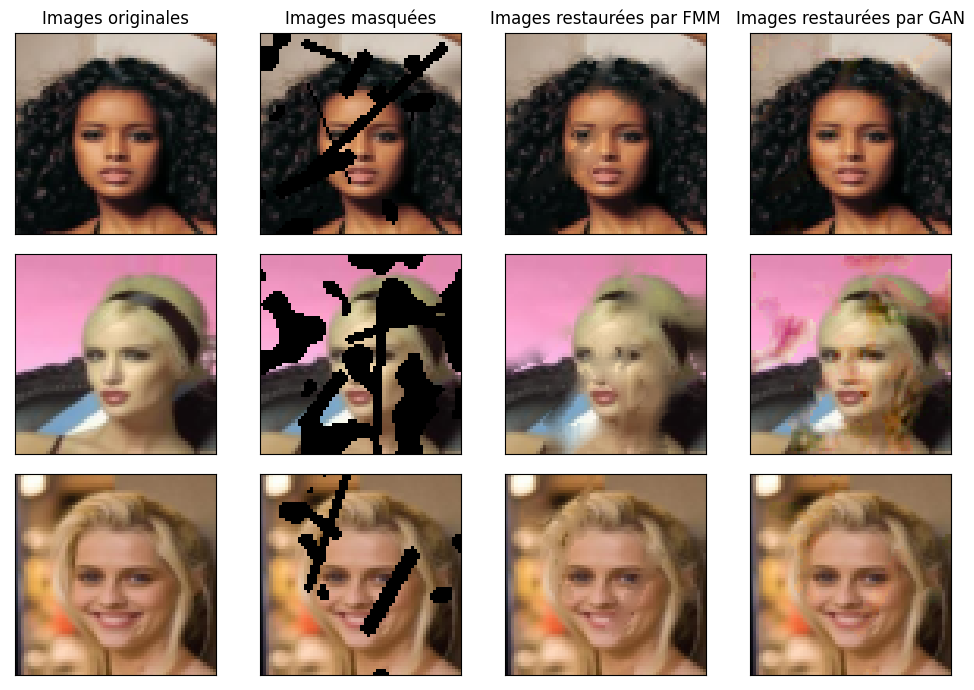

In [746]:
padding_data = torch.load('test_data.pt')
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(10, 7))
for i, (masked_img, mask, original_img) in enumerate(masked_dataset):
    if i < 10:
        pass
    else:

        try:
            ax[i-10]
        except:
            break
        # Convert the PyTorch tensors to numpy arrays

        img_masked = masked_img.clone()

        masked_img = masked_img.permute(1, 2, 0).numpy()
        a = masked_img.copy()
        mask = mask[0].numpy()

        # Inpaint the masked image
        inpainted_img = inpaint(masked_img, 1 - mask, radius=5)  # The mask needs to be inverted because the inpaint function expects the mask to be 1 for known pixels and 0 for unknown pixels

        # Convert the inpainted image back to a PyTorch tensor
        inpainted_img = torch.from_numpy(inpainted_img).permute(2, 0, 1)

        # Inpaint image with GAN
        img_masked_combined = torch.cat((img_masked.unsqueeze(0), padding_data[0][1:])).float()
        mask_combined = torch.cat((torch.tensor(mask).repeat(3, 1, 1).unsqueeze(0), padding_data[1][1:])).float()
        preds = generator_gan_2(img_masked_combined, mask_combined)[0]

        ax[i-10][0].imshow(original_img.permute(1, 2, 0))
        ax[i-10][1].imshow(a)
        ax[i-10][2].imshow(inpainted_img.permute(1, 2, 0))
        ax[i-10][3].imshow(preds.permute(1, 2, 0).detach().numpy())

        for j in ax[i-10]:
            j.set_xticks([])
            j.set_yticks([])
ax[0][0].set_title('Images originales')
ax[0][1].set_title('Images masquées')
ax[0][2].set_title('Images restaurées par FMM')
ax[0][3].set_title('Images restaurées par GAN')
plt.tight_layout()
plt.savefig('test_inpainting_FMM.png')